# Hazard assessment for river flooding using river discharge statistics

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FLOODS](https://github.com/CLIMAAX/FLOODS) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

This workflow uses the dataset of hydrological climate impact indicators by SMHI that is [available via the Copernicus Data Store](https://doi.org/10.24381/cds.73237ad6).

To execute this notebook, the dataset of European river discharges will first be retrieved from the CLIMAAX data server, where a prepared copy is stored for easier and faster access. However, if you would like to download the data directly from CDS or if the dataset copy is not available, you can use the [previous notebook](./hazard_assessment_get_data.ipynb) to download the data.

:::{note}
The plots produced in this notebook are made interactive (when executed by the user), making it possible to explore the data by zooming in or enabling/disabling the data layers. We encourage you to make full use of this functionality to obtain a clear picture of the data.
{tip}

## Preparation work

### Load libraries

`````{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

In this notebook we will use the following Python libraries:

- [os](https://docs.python.org/3/library/os.html) - provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [glob](https://docs.python.org/3/library/glob.html) - library for finding pathnames containing a specified patterns.
- [numpy](https://numpy.org/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [xarray](https://docs.xarray.dev/en/stable/) - library for working with labelled multi-dimensional arrays.
- [geopandas](https://geopandas.org/en/stable/), [pyogrio](https://pyogrio.readthedocs.io/) - libraries for working with geospatial datasets.
- [shapely](https://github.com/shapely/shapely) - library for manipulation and analysis of geometric objects.
- [plotly](https://plotly.com/python/getting-started/) - interactive plotting library.

These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data in this workflow.
`````

In [1]:
import os
from glob import glob

import pooch
import numpy as np
import xarray as xr
import geopandas as gpd
import pyogrio
from shapely.geometry import Point
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Select area of interest
First, we will define the coordinates of the area of interest. Based on these coordinates we will be able to identify the relevant catchment within the river discharges dataset and subset the data for further processing.

The river discharges dataset contants river discharges corresponding to a large number of small-scale catchments. Below we can specify coordinates of a location (WGS84 coordinates) that corresponds to the section of a river that we are interested in. This location will subsequently be snapped to the corresponding catchment in the dataset.

The `locname` variable will be used when adding titles to figures or saving output files.

In [3]:
locname = 'Putna_Romania'
loc = [26.84194444, 45.88861111]

# locname = 'Zilina_Slovakia'
# loc = [18.717, 49.25]

# locname = 'Maastricht_NL'
# loc = [5.697, 50.849]

### Create the directory structure

First, we need to create the directory structure where the inputs and outputs of the workflow are stored.  
In the next cell will create the directory called `FLOOD_RIVER_discharges` in the same directory where this notebook is saved.

If you have already ran the [notebook for downloading](./hazard_assessment_get_data.ipynb) the river discharges dataset directly from CDS, the workflow folder may already be present on your computer, and the pre-processed data is already found in the path defined under `data_folder`. Otherwise, the preprocessed data will be retrieved in this notebook from the CLIMAAX data server.

In [4]:
# Define the folder for the flood workflow
workflow_folder = 'FLOOD_RIVER_discharges'
os.makedirs(workflow_folder, exist_ok=True)

data_folder = os.path.join(workflow_folder, 'data')
os.makedirs(data_folder, exist_ok=True)

In [5]:
# Define directory for plots within the previously defined workflow folder
plot_dir = os.path.join(workflow_folder, f'plots_{locname}')
os.makedirs(plot_dir, exist_ok=True)

## Data selection

### Checking data availability

In this step we will check if the necessary data is already available in the workflow folder or access it from the [CLIMAAX cloud storage](https://handbook.climaax.eu/resources/datasets/river_discharges_mirror.html).

In [6]:
def open_dataset(file, message='', folder=data_folder):
    local_path = os.path.join(folder, file)
    if os.path.exists(local_path):
        print(f'Dataset of {message} is already downloaded.')
        return xr.open_dataset(local_path)
    else:
        print(f'Accessing the dataset of {message} from CLIMAAX cloud storage.')
        file, _ = os.path.splitext(file)
        return xr.open_zarr(f'https://object-store.os-api.cci1.ecmwf.int/climaax/river_discharge_mirror/{file}.zarr')

We will open the four datasets in order to use them in the subsequent analysis. Below we can also check the contents of each file:

In [7]:
ds_day = open_dataset('rdis_day_E-HYPEcatch_allmodels.nc', message='daily river discharges')
ds_day

Dataset of daily river discharges is already downloaded.


<xarray.Dataset> Size: 37GB
Dimensions:     (catchmodel: 8, gcm_rcm: 6, time: 5479, id: 34810)
Coordinates:
  * catchmodel  (catchmodel) <U20 640B 'E-HYPEcatch00-EUR-11' ... 'E-HYPEcatc...
  * gcm_rcm     (gcm_rcm) <U33 792B 'ICHEC-EC-EARTH_CLMcom-CCLM4-8-17' ... 'M...
  * time        (time) datetime64[ns] 44kB 1991-01-01 1991-01-02 ... 2005-12-31
  * id          (id) int32 139kB 8801654 8000123 8212459 ... 9605711 9601936
Data variables:
    rdis        (catchmodel, gcm_rcm, time, id) float32 37GB ...
Attributes: (12/26)
    CDI:                      Climate Data Interface version 1.9.5 (http://mp...
    CDO:                      Climate Data Operators version 1.9.5 (http://mp...
    source:                   A set of EURO-CORDEX EUR-11 RCMS were bias adju...
    institution:              SMHI, www.smhi.se
    Conventions:              CF-1.6
    NCO:                      4.4.8
    ...                       ...
    invar_experiment_name:    rcp45
    invar_rcm_model_id:       CLMcom-CCLM4-8-17
    history:                  
    time_period:              1991-2000
    contact:                  copernicus-support@ecmwf.int
    data_quality:             C3S_424_SMHI uses state of the art, quality con...

In [8]:
ds_mon = open_dataset('rdis_ymonmean_abs_E-HYPEcatch_allmodels.nc', message='monthly mean river discharges')
ds_mon

Dataset of monthly mean river discharges is already downloaded.


<xarray.Dataset> Size: 963MB
Dimensions:        (time_period: 4, scenario: 3, catchmodel: 8, gcm_rcm: 6,
                    time: 12, id: 34810)
Coordinates:
  * time_period    (time_period) <U9 144B '1971-2000' ... '2071-2100'
  * catchmodel     (catchmodel) <U20 640B 'E-HYPEcatch00-EUR-11' ... 'E-HYPEc...
  * gcm_rcm        (gcm_rcm) <U36 864B 'ICHEC-EC-EARTH_CLMcom-CCLM4-8-17-v1' ...
  * time           (time) float64 96B 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0
  * id             (id) int32 139kB 8801654 8000123 8212459 ... 9605711 9601936
  * scenario       (scenario) <U10 120B 'historical' 'rcp45' 'rcp85'
Data variables:
    rdis_ymonmean  (time_period, scenario, catchmodel, gcm_rcm, time, id) float32 962MB ...
Attributes: (12/28)
    CDI:                      Climate Data Interface version 1.9.5 (http://mp...
    Conventions:              CF-1.6
    NCO:                      netCDF Operators version 4.7.7 (Homepage = http...
    comment:                  -
    CDO:                      Climate Data Operators version 1.9.5 (http://mp...
    history:                  CDO commands (last cdo command first and separa...
    ...                       ...
    invar_hm_model_id:        Hydrological models in the order of the variabl...
    invar_experiment_name:    rcp45
    time_coverage_start:      19710101
    time_coverage_end:        20001231
    variable_name:            rdis_ymonmean
    contact:                  copernicus-support@ecmwf.int

In [9]:
ds_flood = open_dataset('rdis_extremes_abs_E-HYPEcatch_allmodels.nc', message='extreme river discharges (absolute values)')
ds_flood

Dataset of extreme river discharges (absolute values) is already downloaded.


<xarray.Dataset> Size: 20MB
Dimensions:                (scenario: 3, gcm_rcm: 6, time: 4, id: 34810)
Coordinates:
  * scenario               (scenario) <U10 120B 'historical' 'rcp45' 'rcp85'
  * gcm_rcm                (gcm_rcm) <U36 864B 'ICHEC-EC-EARTH_CLMcom-CCLM4-8...
  * id                     (id) int32 139kB 8801654 8000123 ... 9605711 9601936
  * time                   (time) datetime64[ns] 32B 1971-01-01 ... 2071-01-01
    time_period            (time) <U9 144B ...
Data variables:
    rdisreturnmax10_tmean  (scenario, gcm_rcm, time, id) float32 10MB ...
    rdisreturnmax50_tmean  (scenario, gcm_rcm, time, id) float32 10MB ...
Attributes: (12/29)
    CDI:                      Climate Data Interface version 1.8.2 (http://mp...
    Conventions:              CF-1.6
    NCO:                      netCDF Operators version 4.7.7 (Homepage = http...
    frequency:                year
    CDO:                      Climate Data Operators version 1.8.2 (http://mp...
    comment:                  -
    ...                       ...
    invar_hm_model_id:        Hydrological models in the order of the variabl...
    invar_experiment_name:    rcp45
    time_coverage_start:      19710101
    time_coverage_end:        20001231
    variable_name:            rdisreturnmax10_tmean
    contact:                  copernicus-support@ecmwf.int

In [10]:
ds_flood_rel = open_dataset('rdis_extremes_rel_E-HYPEcatch_allmodels.nc', message='extreme river discharges (relative change)')
ds_flood_rel

Dataset of extreme river discharges (relative change) is already downloaded.


<xarray.Dataset> Size: 10MB
Dimensions:                (scenario: 2, gcm_rcm: 6, time: 3, id: 34810)
Coordinates:
  * scenario               (scenario) <U5 40B 'rcp45' 'rcp85'
  * gcm_rcm                (gcm_rcm) <U36 864B 'ICHEC-EC-EARTH_CLMcom-CCLM4-8...
  * id                     (id) int32 139kB 8801654 8000123 ... 9605711 9601936
  * time                   (time) datetime64[ns] 24B 2011-01-01 ... 2071-01-01
    time_period            (time) <U9 108B ...
Data variables:
    rdisreturnmax10_tmean  (scenario, gcm_rcm, time, id) float32 5MB ...
    rdisreturnmax50_tmean  (scenario, gcm_rcm, time, id) float32 5MB ...
Attributes: (12/30)
    CDI:                      Climate Data Interface version 1.8.2 (http://mp...
    Conventions:              CF-1.6
    NCO:                      netCDF Operators version 4.7.7 (Homepage = http...
    frequency:                year
    comment:                  -
    CDO:                      Climate Data Operators version 1.8.2 (http://mp...
    ...                       ...
    invar_experiment_name:    rcp45
    time_coverage_start:      20110101
    time_coverage_end:        20401231
    reference_period:         1971-2000
    variable_name:            rdisreturnmax10_tmean
    contact:                  copernicus-support@ecmwf.int

### Load catchment dataset

The river discharges dataset contains discharges corresponding to a large number of small-scale catchments, identified using a catchment ID (coordinate `id` in the dataset). For further analysis, we need to be able to subset the dataset to a specific catchment in our area of interest. In order to know the ID of the catchment we are interested in, we need to consult the [map of catchments (sub-basins)](https://doi.org/10.5281/zenodo.581451).

In [11]:
data_folder_subbasins = os.path.join(data_folder, 'EHYPE3_subbasins')
os.makedirs(data_folder_subbasins, exist_ok=True)

Download the dataset of subbasins from Zenodo:
The next cell will retrieve the files automatically and place them in the folder specied as `data_folder_subbasins` located in the `data_folder` (created in the previous cell).
You can also download the dataset from the Zenodo web interface, unzip it and place it in the folder manually.

In [12]:
pooch.retrieve(
    'doi:10.5281/zenodo.581451/EHYPE3_subbasins.zip',
    known_hash='ce1a48393adba92443fb99cb2651b7cfadf60af9e4cce0ad9cae8e7b52d3c684',
    fname='EHYPE3_subbasins.zip',
    path=data_folder,
    downloader=pooch.DOIDownloader(),
    processor=pooch.Unzip(extract_dir=os.path.basename(data_folder_subbasins))
)

['C:\\git\\CLIMAAX\\FLOODS\\04_River_discharge_analysis\\FLOOD_RIVER_discharges\\data\\EHYPE3_subbasins\\EHYPE3_subbasins.dbf',
 'C:\\git\\CLIMAAX\\FLOODS\\04_River_discharge_analysis\\FLOOD_RIVER_discharges\\data\\EHYPE3_subbasins\\EHYPE3_subbasins.prj',
 'C:\\git\\CLIMAAX\\FLOODS\\04_River_discharge_analysis\\FLOOD_RIVER_discharges\\data\\EHYPE3_subbasins\\EHYPE3_subbasins.shp',
 'C:\\git\\CLIMAAX\\FLOODS\\04_River_discharge_analysis\\FLOOD_RIVER_discharges\\data\\EHYPE3_subbasins\\EHYPE3_subbasins.shx']

We can open the dataset of catchment contours as a GeoDataFrame variable:

In [13]:
try:
    catchments = gpd.GeoDataFrame.from_file(
        os.path.join(data_folder_subbasins, 'EHYPE3_subbasins.shp')
    )
    print('Dataset loaded.')
except pyogrio.errors.DataSourceError:
    print(
        'Dataset with subbasin contours not found. '
        f'Please download it and place it in the folder {data_folder_subbasins}'
    )

catchments = catchments.set_index(catchments['SUBID'].astype(int))
catchments

Dataset loaded.


,SUBID,HAROID,geometry
SUBID,,,
8801544,8801544.0,8801544.0,"MULTIPOLYGON (((-22.9068 65.75671, -22.92437 6..."
8801548,8801548.0,8801548.0,"POLYGON ((-24.42223 65.55144, -24.39406 65.537..."
8000005,8000005.0,8000006.0,"MULTIPOLYGON (((9.3944 59.15315, 9.41203 59.14..."
8115258,8115258.0,8000006.0,"POLYGON ((8.5962 59.30061, 8.59918 59.29174, 8..."
8115717,8115717.0,8000006.0,"POLYGON ((9.27409 59.01988, 9.27962 59.00213, ..."
...,...,...,...
9566395,9566395.0,9566395.0,"POLYGON ((0.15417 49.37083, 0.15417 49.3625, 0..."
9581818,9581818.0,9581818.0,"MULTIPOLYGON (((-4.89583 55.7375, -4.87917 55...."
9524166,9524166.0,9524166.0,"MULTIPOLYGON (((-1.12917 45.34583, -1.12083 45..."


### Selecting the catchment of interest

Now we need to identify the id of the catchment where the point of interest is located based on the coordinates stored in the variable `loc`:

In [14]:
point = Point((loc[0], loc[1]))

in_catchment = catchments.geometry.contains(point)

catch_id = catchments[in_catchment].index.values[0]
print(f'Catchment ID in the E-HYPEcatch dataset: {catch_id}')

Catchment ID in the E-HYPEcatch dataset: 9601909


The catchment ID and contours will be stored in the variable `catchment`.

In [15]:
catchment = catchments.loc[[catch_id]]
catchment

,SUBID,HAROID,geometry
SUBID,,,
9601909,9601909.0,9600704.0,"POLYGON ((26.77084 46.00417, 26.77084 45.99583..."


Below, the catchment contours will be plotted on a map to check whether the correct catchment is selected. The coordinates of the selected location are indicated as a red dot, and contours of the corresponding catchment are displayed, as well as the surrounding catchments.

In [16]:
# Creating a marker for the selected catchment (used in the visualization on the map)
catchments['select'] = np.where(catchments.index==catch_id, 1, 0)

# Select only the nearby catchments within the radius of 1 degree
catchments_sel = catchments.cx[(loc[0]-1):(loc[0]+1), (loc[1]-1):(loc[1]+1)]

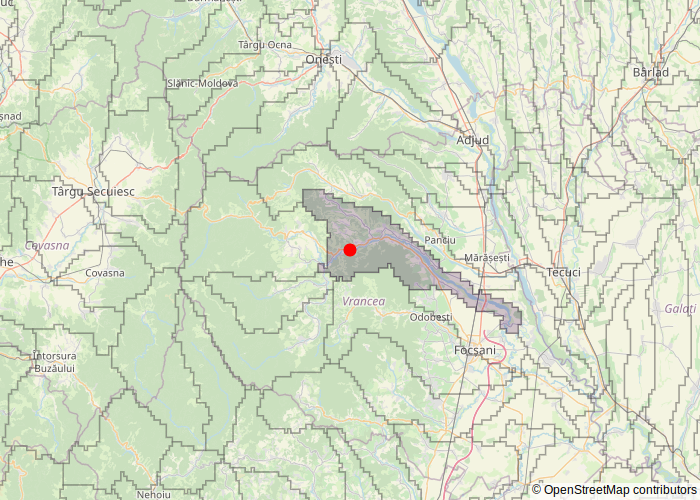

In [17]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    lat=[loc[1]],  # Latitude coordinates
    lon=[loc[0]],   # Longitude coordinates
    mode='markers',
    marker=go.scattermapbox.Marker(size=14, color='red'),
    text=['Location of interest'],  # Labels for the points
    name=''
))

fig.add_trace(go.Choroplethmapbox(
    geojson=catchments_sel.to_geo_dict(),
    locations=catchments_sel.index,
    z=catchments_sel['select'],  
    hoverinfo='text',
    text=catchments_sel['SUBID'],  
    colorscale='RdPu',
    marker={'line': {'color': 'black', 'width': 1.5}},
    marker_opacity=0.2,  
    showscale=False
))

fig.update_layout(
    mapbox_center={'lat': loc[1], 'lon': loc[0]},
    mapbox_zoom=8,
    margin={'r': 0, 't': 0, 'l': 0, 'b': 0},
    mapbox={'style': 'open-street-map'})

fig.show()

fig.write_image(os.path.join(plot_dir, f'{locname}_location_catchment_map.png'))

Based on the map above, we can evaluate whether we want to proceed with analysing modelled river discharges for the selected catchment. If you would like to change the catchment selection, you can go back to the start of this notebook and adjust the location coordinates.

## Evaluating daily values of historical river discharges

We will create dataset variable `ds_day_sel` which will contain the daily timeseries of river discharges only for the selected catchment:

In [18]:
ds_day_sel = ds_day.sel(id=catch_id).compute(); del ds_day

We can explore the timeseries of daily river discharges for the historical model period by plotting the entire dataset. By default we have selected a 5 year period (2001-2005). The plot below shows the timeseries based on different GCM-RCM climate model combinations in separate panels. Please note that these climate models are not constrained by real-world observations, but are aiming to represent one possible realization of the climate in that period. Therefore, the daily timeseries are not representative for analyzing individual past weather events - in the plot below we see different discharge patterns for the different GCM-RCM combinations.   

The different lines on each plot correspond to the model results for different catchment models, and are helpful in assessing the uncertainty caused by the different assumptions in the hydrological model.

In [19]:
str_daily_timerange = f'{ds_day_sel.time.dt.year.values[0]}-{ds_day_sel.time.dt.year.values[-1]}'
str_daily_timerange

'1991-2005'

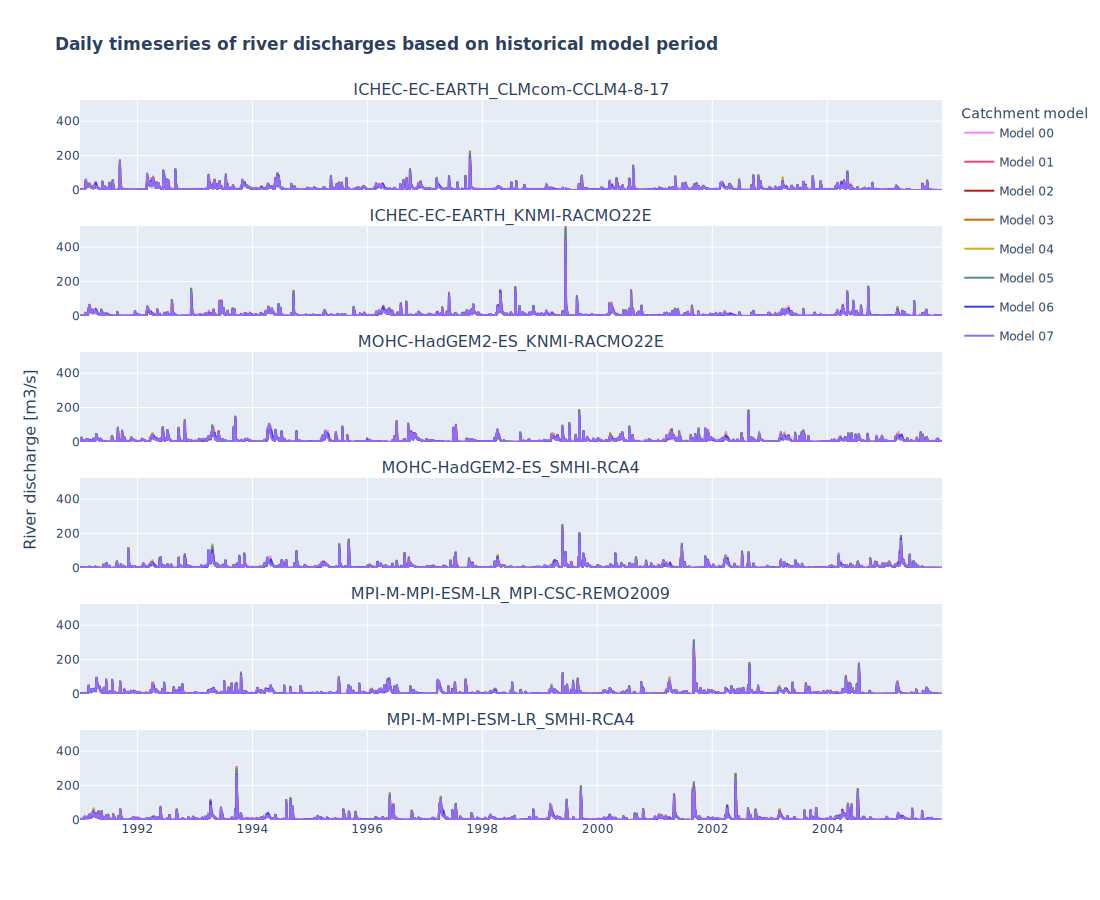

In [20]:
# Create a figure
fig = make_subplots(
    rows=len(ds_day_sel.gcm_rcm),
    cols=1,
    shared_xaxes=True,
    y_title='River discharge [m3/s]',
    vertical_spacing=0.05,
    subplot_titles=ds_day_sel.gcm_rcm.values
)

colorlist = px.colors.cyclical.mrybm[::2]

for ii, catchmodel in enumerate(ds_day_sel.catchmodel.values):
    for mm, gcm_rcm in enumerate(ds_day_sel.gcm_rcm.values):
        fig.add_trace(go.Scatter(x=ds_day_sel.time, y=ds_day_sel.rdis.sel(gcm_rcm=gcm_rcm, catchmodel=catchmodel), 
                                mode='lines', line={'color': colorlist[ii]}, name=f'Model {ii:02}', 
                                legendgroup=f'Model {ii:02}', showlegend=(mm==0)), row=mm+1, col=1)

fig.update_yaxes(range=[0, np.max(ds_day_sel.rdis.values)])

# Customize layout
fig.update_layout(
    height=900, width=1100, 
    title_text='<b>Daily timeseries of river discharges based on historical model period</b>',
    legend_title_text='Catchment model',
)

# Show the figure
fig.show()

# Save figure
fig.write_image(os.path.join(plot_dir,f'{locname}_daily_timeseries_{str_daily_timerange}.png'))

Going forward, we will take the mean values across the `catchmodel` models in order to analyze a single timeseries per GCM-RCM combination. Below we plot the timeseries averaged over catchment models for all GCM-RCM combinations in one plot:

In [21]:
ds_day_sel_catchmean = ds_day_sel.rdis.mean(dim='catchmodel')

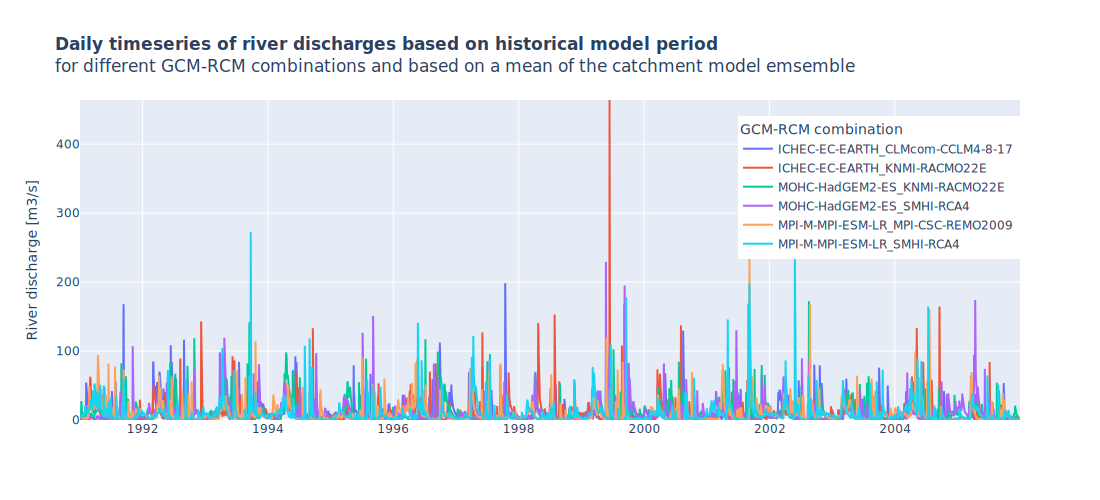

In [22]:
# Create a figure
fig = go.Figure()

for gcm_rcm in ds_day_sel.gcm_rcm.values:
    fig.add_trace(go.Scatter(x=ds_day_sel.time, y=ds_day_sel_catchmean.sel(gcm_rcm=gcm_rcm), mode='lines', name=gcm_rcm))

fig.update_yaxes(range=[0, np.max(ds_day_sel_catchmean.values)])

# Customize layout
fig.update_layout(
    height=500, width=1100, 
    title_text=(
        '<b>Daily timeseries of river discharges based on historical model period</b>'
        '<br>for different GCM-RCM combinations and based on a mean of the catchment model emsemble'
    ),
    yaxis_title='River discharge [m3/s]',
    showlegend=True,
    legend_title_text='GCM-RCM combination',
    legend={'x': 0.7, 'y': 0.95},
)

# Show the figure
fig.show()

# Save figure
fig.write_image(os.path.join(plot_dir, f'{locname}_daily_timeseries_{str_daily_timerange}_catchmodelmean.png'))

### Flow-duration curve

Daily discharge statistics are a useful metric for understanding how representative the model results are compared to the local observations. If we have access to measured daily discharge values, we can compare the exceedance curves of the daily discharges, also known as the flow-duration curve. We can compute the flow duration curve based on the modelled data below:

In [23]:
ds_flow_curve = xr.DataArray(
    data=-np.sort(-ds_day_sel_catchmean.values, axis=1),
    dims=['gcm_rcm', 'exceedance'],
    coords={
        'gcm_rcm': ds_day_sel_catchmean.gcm_rcm.values,
        'exceedance': np.arange(1., len(ds_day_sel_catchmean.time)+1) / len(ds_day_sel_catchmean.time) * 100,
    }
)

The resulting flow-duration curve is plotted below. The plot is interactive and makes it possible to zoom in and inspect the data, as well as to (de)select GCM-RCM model combinations in the legend.  

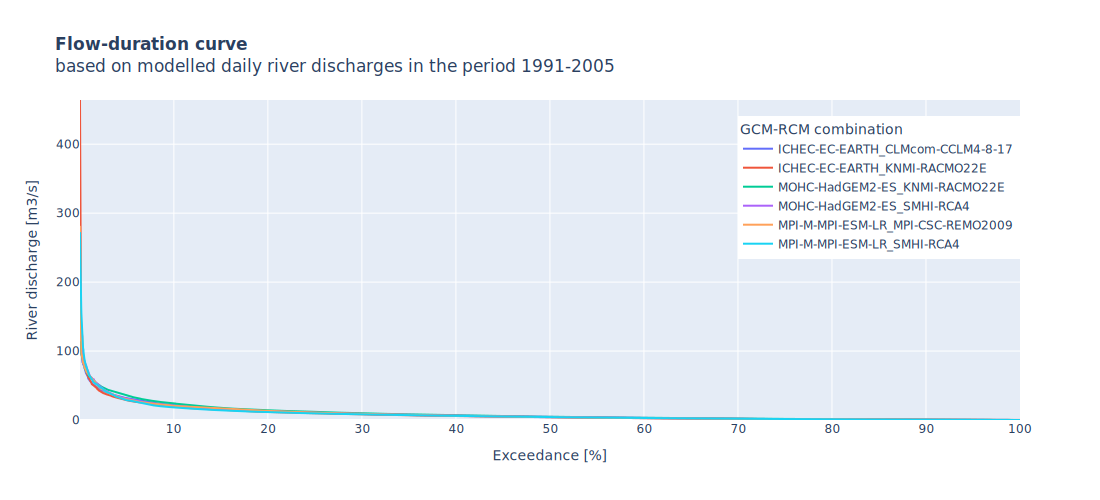

In [24]:
# Create a figure
fig = go.Figure()

for gcm_rcm in ds_day_sel.gcm_rcm.values:
    fig.add_trace(go.Scatter(x=ds_flow_curve.exceedance, y=ds_flow_curve.sel(gcm_rcm=gcm_rcm), mode='lines', name=gcm_rcm))

fig.update_yaxes(range=[0, np.max(ds_flow_curve.values)])

# Customize layout
fig.update_layout(
    height=500, width=1100, 
    title_text=f'<b>Flow-duration curve</b><br>based on modelled daily river discharges in the period {str_daily_timerange}',
    yaxis_title='River discharge [m3/s]',
    xaxis_title='Exceedance [%]',
    showlegend=True,
    legend_title_text='GCM-RCM combination',
    legend={'x': 0.7, 'y': 0.95},
)

# Show the figure
fig.show()

# Save figure
fig.write_image(os.path.join(plot_dir,f'{locname}_flow-duration_curve_{str_daily_timerange}.png'))

For an accurate flow-duration curve, we need to consider a longer time period. As a minimum, we recommend 15 years of data (e.g. 1991-2005). 

The flow-duration curve above can be compared to the curve derived from local river discharge observations in order to understand how well the model represents both the seasonal and extreme discharges. For this workflow, especially the representation of extreme (low probability events) discharges is important.

Consider the following questions:
- Are the extremes of the same order of magnitude?
- is the shape of the flow-duration curve based on model data similar to the observed data?

### Possibility to exclude certain GCM-RCM model combinations from the analysis
The statistics of some GCM-RCM combinations might be closer to the observed discharge statistics than others. Based on this, it can be useful exclude certain GCM-RCM combinations from the subsequent analysis, e.g. if the mode data showa statistical behavior that is very different from observations and from the other GCM-RCM combinations. This can be done by adding the name of the GCM-RCM combination to the list variable `exclude_gcm_rcm` below.

:::{tip}
If you do not want to exclude any GCM-RCM combinations, please set the variable `exclude_gcm_rcm` to an empty list `[]`.
:::

In [25]:
print('Avalable GCM-RCM combinations:')
print('\n'.join(ds_day_sel.gcm_rcm.values))

Avalable GCM-RCM combinations:
ICHEC-EC-EARTH_CLMcom-CCLM4-8-17
ICHEC-EC-EARTH_KNMI-RACMO22E
MOHC-HadGEM2-ES_KNMI-RACMO22E
MOHC-HadGEM2-ES_SMHI-RCA4
MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009
MPI-M-MPI-ESM-LR_SMHI-RCA4


In [26]:
exclude_gcm_rcm = [] # set to empty list [] if you do not want to exclude any model combinations

In [27]:
if exclude_gcm_rcm == []:
    print('No model combination is excluded.')
else:
    for ii, gcm_rcm in enumerate(exclude_gcm_rcm):
        if gcm_rcm in ds_day_sel.gcm_rcm.values:
            print(f'{gcm_rcm} will be excluded from further analysis.')
        else:
            print(f'Model combination {gcm_rcm} not found, please check correctness.')

No model combination is excluded.


## Analysing the seasonal variations of river discharges

We will check the seasonal variations in the modelled historical river discharges, and check how they differ between the different climate scenarios.

We start by selecting the data for the specific catchment from the dataset of monthly mean river discharges containing data for different time periods and climate scenarios. We will directly take a mean across catchment models to simplify the futher assessment.

In [28]:
ds_mon_sel = ds_mon.sel(id=catch_id).compute().mean(dim='catchmodel')
ds_mon_sel

<xarray.Dataset> Size: 5kB
Dimensions:        (time_period: 4, scenario: 3, gcm_rcm: 6, time: 12)
Coordinates:
  * time_period    (time_period) <U9 144B '1971-2000' ... '2071-2100'
  * gcm_rcm        (gcm_rcm) <U36 864B 'ICHEC-EC-EARTH_CLMcom-CCLM4-8-17-v1' ...
  * time           (time) float64 96B 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0
    id             int32 4B 9601909
  * scenario       (scenario) <U10 120B 'historical' 'rcp45' 'rcp85'
Data variables:
    rdis_ymonmean  (time_period, scenario, gcm_rcm, time) float32 3kB 3.926 ....

If any model names were specified in the variable `exclude_gcm_rcm` to be excluded, these will be filtered out below:

In [29]:
exclude_list = []
if exclude_gcm_rcm is not []:
    for gcm_rcm in exclude_gcm_rcm:
        exclude_list = exclude_list + [x for x in ds_mon_sel.gcm_rcm.values.tolist() if gcm_rcm in x]
    print(exclude_list)

[]


In [30]:
# Exclude selected GCM-RCM model combinations
ds_mon_sel = ds_mon_sel.drop_sel(gcm_rcm=exclude_list)
ds_mon_sel

<xarray.Dataset> Size: 5kB
Dimensions:        (time_period: 4, scenario: 3, gcm_rcm: 6, time: 12)
Coordinates:
  * time_period    (time_period) <U9 144B '1971-2000' ... '2071-2100'
  * gcm_rcm        (gcm_rcm) <U36 864B 'ICHEC-EC-EARTH_CLMcom-CCLM4-8-17-v1' ...
  * time           (time) float64 96B 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0
    id             int32 4B 9601909
  * scenario       (scenario) <U10 120B 'historical' 'rcp45' 'rcp85'
Data variables:
    rdis_ymonmean  (time_period, scenario, gcm_rcm, time) float32 3kB 3.926 ....

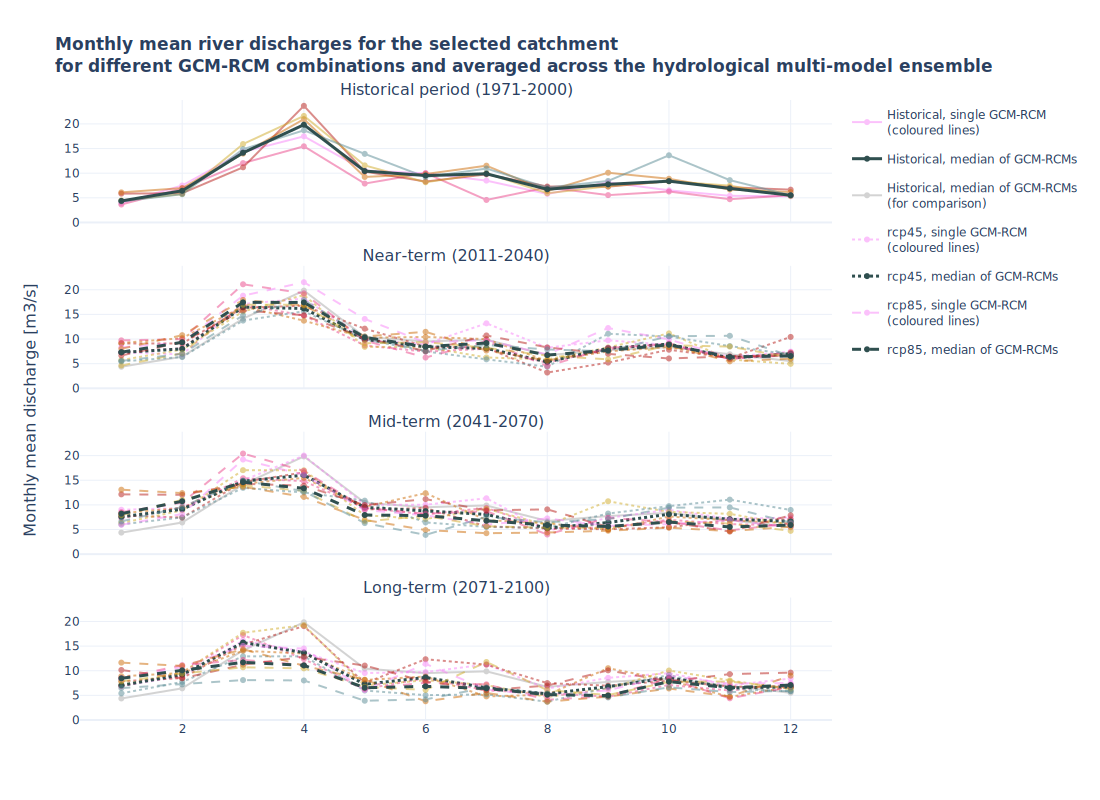

In [31]:
# Create a figure
fig = make_subplots(
    rows=4,
    cols=1,
    shared_xaxes=True,
    y_title='Monthly mean discharge [m3/s]',
    vertical_spacing=0.07,
    subplot_titles=[
        'Historical period (1971-2000)', 
        'Near-term (2011-2040)', 
        'Mid-term (2041-2070)',
        'Long-term (2071-2100)'
    ]
)

dashlist = ['dot', 'dash']

for ii, gcm_rcm in enumerate(ds_mon_sel.gcm_rcm.values):
    fig.add_trace(go.Scatter(x=ds_mon_sel.time, y=ds_mon_sel.rdis_ymonmean.sel(gcm_rcm=gcm_rcm, time_period='1971-2000', scenario='historical'), 
                             mode='lines+markers', line={'color': colorlist[ii]}, opacity=0.5, 
                             name=f'Historical, single GCM-RCM<br>(coloured lines)', 
                             legendgroup=f'Historical, single GCM-RCM', text=f'{gcm_rcm}', showlegend=(ii==0)), row=1, col=1)
    
fig.add_trace(go.Scatter(x=ds_mon_sel.time, y=ds_mon_sel.rdis_ymonmean.sel(time_period='1971-2000', scenario='historical').median(dim='gcm_rcm'), 
                            mode='lines+markers', line={'color': 'darkslategray', 'width': 3}, name=f'Historical, median of GCM-RCMs', 
                            text=f'Historical (1971-2000), GCM-RCM median'), row=1, col=1)

for tt, time_period in enumerate(ds_mon_sel.time_period.values[1:]):

    fig.add_trace(go.Scatter(x=ds_mon_sel.time, y=ds_mon_sel.rdis_ymonmean.sel(time_period='1971-2000', scenario='historical').median(dim='gcm_rcm'), 
                            mode='lines+markers', line={'color': 'lightgrey'}, name=f'Historical, median of GCM-RCMs<br>(for comparison)',
                            legendgroup=f'Historical, median of GCM-RCM combinations', text=f'Historical (1971-2000), median of GCM-RCMs',
                            showlegend=(tt==0)), row=tt+2, col=1)   
    
    for ss, scen in enumerate(ds_mon_sel.scenario.values[1:]):
        for ii, gcm_rcm in enumerate(ds_mon_sel.gcm_rcm.values):
            fig.add_trace(go.Scatter(x=ds_mon_sel.time, y=ds_mon_sel.rdis_ymonmean.sel(gcm_rcm=gcm_rcm, scenario=scen, time_period=time_period), 
                                    mode='lines+markers', line={'color': colorlist[ii], 'dash': dashlist[ss]}, opacity=0.5, 
                                    name=f'{scen}, single GCM-RCM<br>(coloured lines)', legendgroup=f'{scen}, single GCM-RCM', 
                                    text=f'{gcm_rcm}', showlegend=(ii==0 and tt==0)), row=tt+2, col=1)
        
        fig.add_trace(go.Scatter(x=ds_mon_sel.time, y=ds_mon_sel.rdis_ymonmean.sel(scenario=scen, time_period=time_period).median(dim='gcm_rcm'), 
                                    mode='lines+markers', line={'color': 'darkslategray', 'width': 3, 'dash': dashlist[ss]}, name=f'{scen}, median of GCM-RCMs', 
                                    text=f'{scen} ({time_period}), median of GCM-RCMs', showlegend=(tt==0)), row=tt+2, col=1)

fig.update_yaxes(range=[0, np.nanmax(ds_mon_sel.rdis_ymonmean.values)*1.05])

# Customize layout
fig.update_layout(
    height=800, width=1100, 
    title_text=(
        '<b>Monthly mean river discharges for the selected catchment<br>'
        'for different GCM-RCM combinations and averaged across the hydrological multi-model ensemble</b>'
    ),
    showlegend=True,
    template='plotly_white',
)

# Show the figure
fig.show()

# Save figure
fig.write_image(os.path.join(plot_dir, f'{locname}_monthly_means.png'))

By exploring the plot above, we can learn more about the projected shifts in river discharge seasonality.

It is recommended to compare the plot above (the upper panel for the historical period) to a similar plot based on local river discharge observations. This can provide more insight into the similarities and differences between modelled and observed discharges.

Regarding the change in monthly river discharges for different climate scenarios and timeframes, consider the following questions:
- Is there a general trend towards "wetter" or "drier" climate?
- In which parts of the year do you see a significant change in river discharges?
- How do the peak monthly discharges shift in time? A shift in the seasonal profile can be caused by e.g. the changing timing and volume of snowmelt.

## Flood occurence in historical and future climates

The dataset also contains estimated extreme river discharges for different scenarios that can be used to make the first assessment of the change in extremes due to climate change. This can serve as an indication of the change in flood hazard.  


We will consider both absolute and **relative** change in river discharges, where the latter is especially informative because the absolute values of extremes may not be entirely accurate in the model dataset. We will focus on the extreme river discharges with 10-year and 50-year return periods.

### Absolute values of extreme river discharges in the current and future climate

First we need to subset the dataset of extreme river discharges to the catchment of interest:

In [32]:
# Subset to catchment of interest
ds_flood_sel = ds_flood.sel(id=catch_id).compute()
ds_flood_sel

<xarray.Dataset> Size: 2kB
Dimensions:                (scenario: 3, gcm_rcm: 6, time: 4)
Coordinates:
  * scenario               (scenario) <U10 120B 'historical' 'rcp45' 'rcp85'
  * gcm_rcm                (gcm_rcm) <U36 864B 'ICHEC-EC-EARTH_CLMcom-CCLM4-8...
    id                     int32 4B 9601909
  * time                   (time) datetime64[ns] 32B 1971-01-01 ... 2071-01-01
    time_period            (time) <U9 144B '1971-2000' ... '2071-2100'
Data variables:
    rdisreturnmax10_tmean  (scenario, gcm_rcm, time) float32 288B 193.6 ... 2...
    rdisreturnmax50_tmean  (scenario, gcm_rcm, time) float32 288B 262.1 ... 3...
Attributes: (12/29)
    CDI:                      Climate Data Interface version 1.8.2 (http://mp...
    Conventions:              CF-1.6
    NCO:                      netCDF Operators version 4.7.7 (Homepage = http...
    frequency:                year
    CDO:                      Climate Data Operators version 1.8.2 (http://mp...
    comment:                  -
    ...                       ...
    invar_hm_model_id:        Hydrological models in the order of the variabl...
    invar_experiment_name:    rcp45
    time_coverage_start:      19710101
    time_coverage_end:        20001231
    variable_name:            rdisreturnmax10_tmean
    contact:                  copernicus-support@ecmwf.int

In [33]:
# Exclude selected GCM-RCM model combinations
ds_flood_sel = ds_flood_sel.drop_sel(gcm_rcm=exclude_list)
ds_flood_sel

<xarray.Dataset> Size: 2kB
Dimensions:                (scenario: 3, gcm_rcm: 6, time: 4)
Coordinates:
  * scenario               (scenario) <U10 120B 'historical' 'rcp45' 'rcp85'
  * gcm_rcm                (gcm_rcm) <U36 864B 'ICHEC-EC-EARTH_CLMcom-CCLM4-8...
    id                     int32 4B 9601909
  * time                   (time) datetime64[ns] 32B 1971-01-01 ... 2071-01-01
    time_period            (time) <U9 144B '1971-2000' ... '2071-2100'
Data variables:
    rdisreturnmax10_tmean  (scenario, gcm_rcm, time) float32 288B 193.6 ... 2...
    rdisreturnmax50_tmean  (scenario, gcm_rcm, time) float32 288B 262.1 ... 3...
Attributes: (12/29)
    CDI:                      Climate Data Interface version 1.8.2 (http://mp...
    Conventions:              CF-1.6
    NCO:                      netCDF Operators version 4.7.7 (Homepage = http...
    frequency:                year
    CDO:                      Climate Data Operators version 1.8.2 (http://mp...
    comment:                  -
    ...                       ...
    invar_hm_model_id:        Hydrological models in the order of the variabl...
    invar_experiment_name:    rcp45
    time_coverage_start:      19710101
    time_coverage_end:        20001231
    variable_name:            rdisreturnmax10_tmean
    contact:                  copernicus-support@ecmwf.int

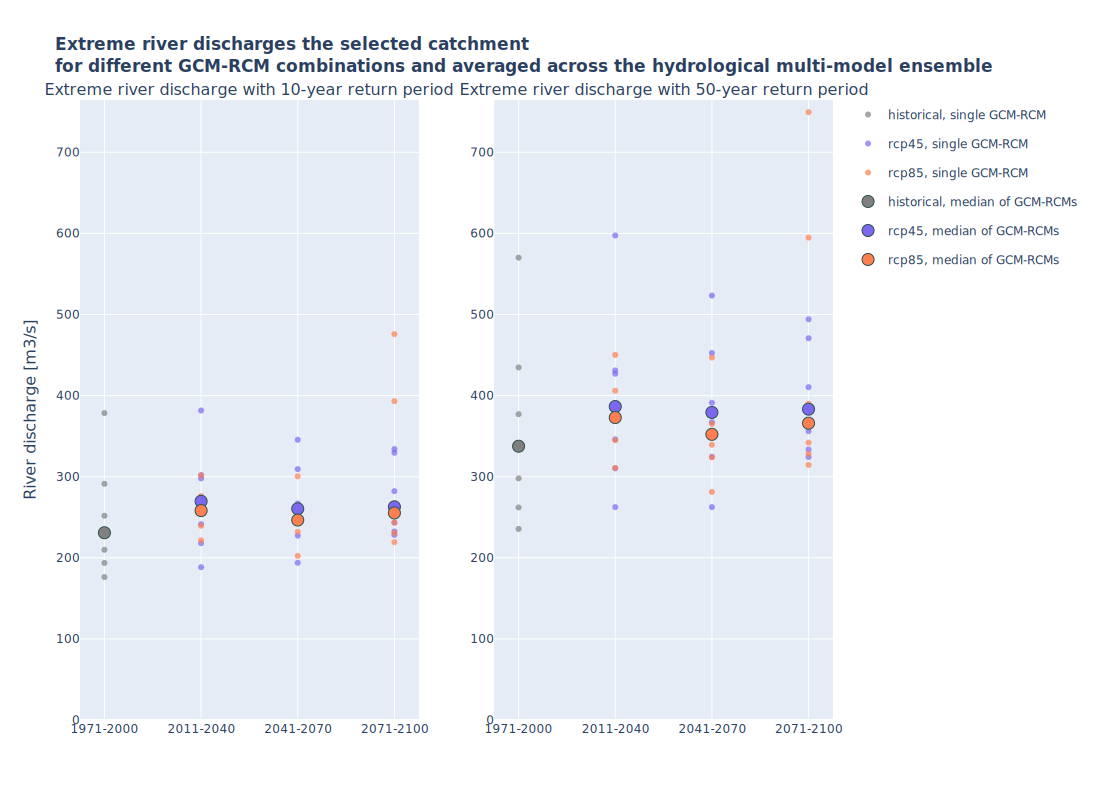

In [34]:
# Create a figure
fig = make_subplots(
    rows=1,
    cols=2,
    shared_xaxes=True,
    y_title='River discharge [m3/s]',
    vertical_spacing=0.07,
    subplot_titles=[
        'Extreme river discharge with 10-year return period', 
        'Extreme river discharge with 50-year return period'
    ]
)

# dashlist = ['dot', 'dash']
colors = ['grey', 'mediumslateblue', 'coral']
x_values = ds_flood_sel.time_period.values

for vnum,varname in enumerate(['rdisreturnmax10_tmean', 'rdisreturnmax50_tmean']):

    for ss,scen in enumerate(['historical', 'rcp45', 'rcp85']):
        for mm, gcm_rcm in enumerate(ds_flood_sel.gcm_rcm.values):
            fig.add_trace(go.Scatter(x=x_values, 
                                    y=ds_flood_sel.sel(scenario=scen, gcm_rcm=gcm_rcm)[varname], 
                                    mode='markers', marker={'color':colors[ss]}, name=f'{scen}, single GCM-RCM', 
                                    text = f'{scen}<br>{gcm_rcm}', showlegend=(mm==0 and vnum==0), opacity=0.7,
                                    legendgroup=f'{scen}'), row=1, col=vnum+1)
            
    for ss,scen in enumerate(['historical', 'rcp45', 'rcp85']):         
        fig.add_trace(go.Scatter(x=x_values, y=ds_flood_sel.sel(scenario=scen)[varname].median(dim='gcm_rcm'), 
                                    mode='markers', marker={'color': colors[ss], 'size': 12, 'line':{'color': 'darkslategrey', 'width': 1}}, 
                                    name=f'{scen}, median of GCM-RCMs', text = f'{scen}<br>GCM-RCM median',
                                    legendgroup=f'{scen}, single GCM-RCM', showlegend=(vnum==0)), row=1, col=vnum+1)

fig.update_yaxes(range=[0, np.nanmax(ds_flood_sel[varname])*1.02])

# Customize layout
fig.update_layout(
    height=800,
    width=1100, 
    title_text=(
        '<b>Extreme river discharges the selected catchment<br>'
        'for different GCM-RCM combinations and averaged across the hydrological multi-model ensemble</b>'
    ),
    showlegend=True,
    #template='plotly_white',
)

# Show the figure
fig.show()

# Save figure
fig.write_image(os.path.join(plot_dir, f'{locname}_extremes_absolute_values.png'))

The plot above provides the first indication in the change in extreme river discharges across scenarios. By hovering above the individual data points, one can check which climate model combination they correspond to.

The river discharge extremes can be affected by large-scale changes in raifall patterns, snowfall and snowmelt patterns, as well as evaporation changes due to changing temperatures. The increase in expected extreme river discharges can be non-linear: it can for example increase on short-term and decrease again later in the century.

Consider the following questions:
- is there a continuous (increasing or decreasing) trend in median extreme discharges?
- is there a large uncertainty across climate models in the medium and long term? 
- Is the uncertainty across models larger for RCP8.5 or is it similar in both climate scenarios?
- Is there a meaningful difference between the extremes projected for RCP4.5 and RCP8.5?

### Relative change in extreme river discharges in the future climate

As a last step, we will visualize the relative change in projected extreme river discharges, which is a better indicator for the flood hazard change than the absolute values above (given possible model biases).

In [35]:
# Subset to catchment of interest
ds_flood_rel_sel = ds_flood_rel.sel(id=catch_id).compute()
ds_flood_rel_sel

<xarray.Dataset> Size: 1kB
Dimensions:                (scenario: 2, gcm_rcm: 6, time: 3)
Coordinates:
  * scenario               (scenario) <U5 40B 'rcp45' 'rcp85'
  * gcm_rcm                (gcm_rcm) <U36 864B 'ICHEC-EC-EARTH_CLMcom-CCLM4-8...
    id                     int32 4B 9601909
  * time                   (time) datetime64[ns] 24B 2011-01-01 ... 2071-01-01
    time_period            (time) <U9 108B '1971-2000' '1971-2000' '1971-2000'
Data variables:
    rdisreturnmax10_tmean  (scenario, gcm_rcm, time) float32 144B 24.7 ... -3...
    rdisreturnmax50_tmean  (scenario, gcm_rcm, time) float32 144B 32.04 ... -...
Attributes: (12/30)
    CDI:                      Climate Data Interface version 1.8.2 (http://mp...
    Conventions:              CF-1.6
    NCO:                      netCDF Operators version 4.7.7 (Homepage = http...
    frequency:                year
    comment:                  -
    CDO:                      Climate Data Operators version 1.8.2 (http://mp...
    ...                       ...
    invar_experiment_name:    rcp45
    time_coverage_start:      20110101
    time_coverage_end:        20401231
    reference_period:         1971-2000
    variable_name:            rdisreturnmax10_tmean
    contact:                  copernicus-support@ecmwf.int

In [36]:
# Exclude selected GCM-RCM model combinations
ds_flood_rel_sel = ds_flood_rel_sel.drop_sel(gcm_rcm=exclude_list)
ds_flood_rel_sel

<xarray.Dataset> Size: 1kB
Dimensions:                (scenario: 2, gcm_rcm: 6, time: 3)
Coordinates:
  * scenario               (scenario) <U5 40B 'rcp45' 'rcp85'
  * gcm_rcm                (gcm_rcm) <U36 864B 'ICHEC-EC-EARTH_CLMcom-CCLM4-8...
    id                     int32 4B 9601909
  * time                   (time) datetime64[ns] 24B 2011-01-01 ... 2071-01-01
    time_period            (time) <U9 108B '1971-2000' '1971-2000' '1971-2000'
Data variables:
    rdisreturnmax10_tmean  (scenario, gcm_rcm, time) float32 144B 24.7 ... -3...
    rdisreturnmax50_tmean  (scenario, gcm_rcm, time) float32 144B 32.04 ... -...
Attributes: (12/30)
    CDI:                      Climate Data Interface version 1.8.2 (http://mp...
    Conventions:              CF-1.6
    NCO:                      netCDF Operators version 4.7.7 (Homepage = http...
    frequency:                year
    comment:                  -
    CDO:                      Climate Data Operators version 1.8.2 (http://mp...
    ...                       ...
    invar_experiment_name:    rcp45
    time_coverage_start:      20110101
    time_coverage_end:        20401231
    reference_period:         1971-2000
    variable_name:            rdisreturnmax10_tmean
    contact:                  copernicus-support@ecmwf.int

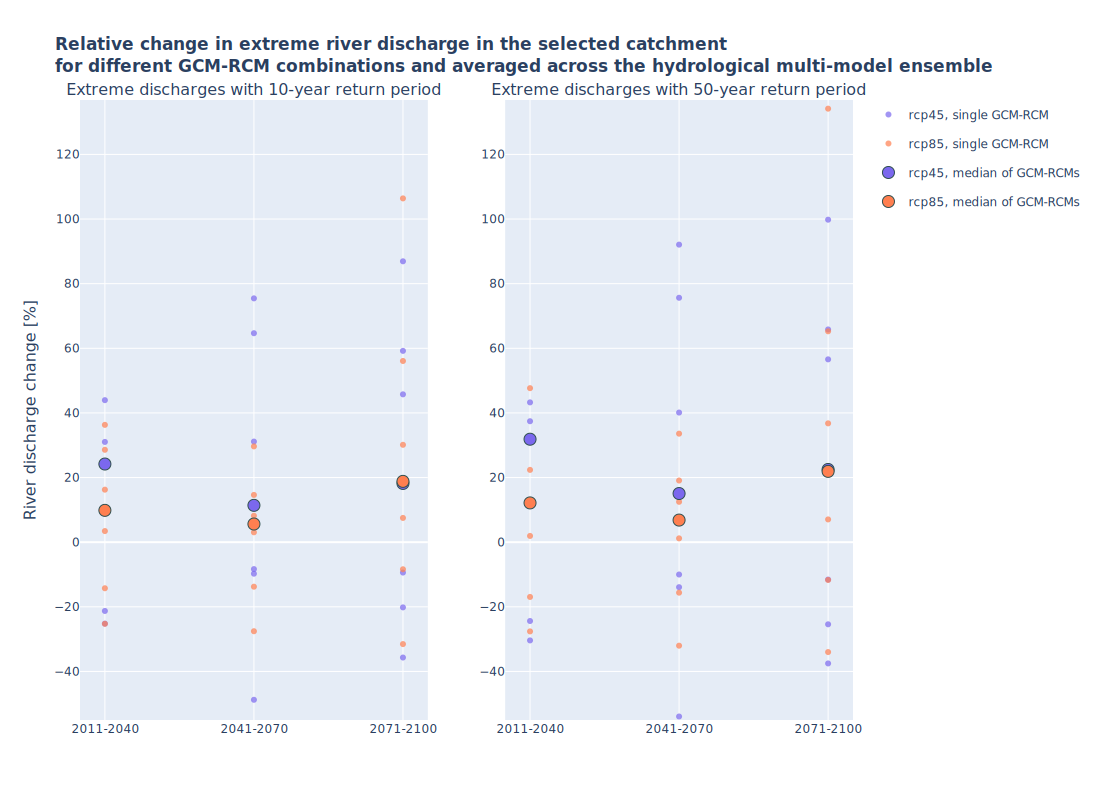

In [37]:
# Create a figure
fig = make_subplots(
    rows=1,
    cols=2,
    shared_xaxes=True,
    y_title='River discharge change [%]',
    subplot_titles=[
        'Extreme discharges with 10-year return period', 
        'Extreme discharges with 50-year return period'
    ]
)

# dashlist = ['dot', 'dash']
colors = ['mediumslateblue', 'coral']
x_values = ds_flood_sel.time_period.values[1:]

for vnum,varname in enumerate(['rdisreturnmax10_tmean', 'rdisreturnmax50_tmean']):

    for ss,scen in enumerate(['rcp45', 'rcp85']):
        for mm, gcm_rcm in enumerate(ds_flood_rel_sel.gcm_rcm.values):
            fig.add_trace(go.Scatter(x=x_values, 
                                    y=ds_flood_rel_sel.sel(scenario=scen, gcm_rcm=gcm_rcm)[varname], 
                                    mode='markers', marker={'color': colors[ss]}, name=f'{scen}, single GCM-RCM', 
                                    text=f'{scen}<br>{gcm_rcm}', showlegend=(mm==0 and vnum==0), opacity=0.7,
                                    legendgroup=f'{scen}'), row=1, col=vnum+1)
            
    for ss,scen in enumerate(['rcp45','rcp85']):         
        fig.add_trace(go.Scatter(x=x_values, y=ds_flood_rel_sel.sel(scenario=scen)[varname].median(dim='gcm_rcm'), 
                                    mode='markers', marker={'color': colors[ss], 'size': 12, 'line':{'color': 'darkslategrey', 'width': 1}}, 
                                    name=f'{scen}, median of GCM-RCMs', text=f'{scen}<br>Median of GCM-RCMs',
                                    legendgroup=f'{scen}, single GCM-RCM', showlegend=(vnum==0)), row=1, col=vnum+1)

fig.update_yaxes(range=[
    np.nanmin(ds_flood_rel_sel[varname])*1.02,
    np.nanmax(ds_flood_rel_sel[varname])*1.02
])

# Customize layout
fig.update_layout(
    height=800,
    width=1100, 
    title_text=(
        '<b>Relative change in extreme river discharge in the selected catchment<br>'
        'for different GCM-RCM combinations and averaged across the hydrological multi-model ensemble</b>'
    ),
    showlegend=True,
)

# Show the figure
fig.show()

# Save figure
fig.write_image(os.path.join(plot_dir, f'{locname}_extremes_relative_values.png'))

The plot above provides additional insight into the changes in extreme river discharges.

Consider the following questions:
- What is the projected increase (or decrease) on medium and long term when considering only median values (across climate models)?
- Is there a meaningful difference between RCP4.5 and RCP8.5 values?
- How large is the uncertainty range across climate models? Are the largest outliers always corresponding to the same GCM-RCM climate model combination or different ones?

## References

- Berg, P., Photiadou, C., Bartosova, A., Biermann, J., Capell, R., Chinyoka, S., Fahlesson, T., Franssen, W., Hundecha, Y., Isberg, K., Ludwig, F., Mook, R., Muzuusa, J., Nauta, L., Rosberg, J., Simonsson, L., Sjökvist, E., Thuresson, J., and van der Linden, E., (2021): Hydrology related climate impact indicators from 1970 to 2100 derived from bias adjusted European climate projections. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: [10.24381/cds.73237ad6](https://doi.org/10.24381/cds.73237ad6)
- Isberg, K. (2017). EHYPE3_subbasins.zip [Data set]. Zenodo. https://doi.org/10.5281/zenodo.581451

## Contributors

Author of the workflow: Natalia Aleksandrova (Deltares)